# Telegram chat history analysis 

just for lulz

Parsing using **telethon**

## Autorization

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from telethon import TelegramClient

import pandas as pd
import numpy as np

from collections import Counter
import time


api_id = XXX
api_hash = 'XXX'
phone_number = '+XXX'

client = TelegramClient('session_id', api_id=api_id, api_hash=api_hash)

# client.start()
assert client.connect()

if not client.is_user_authorized():
    client.send_code_request(phone_number)
    me = client.sign_in(phone_number, input('Enter code: '))
    print(me.stringify())
    
chat_id = -1001132423352

## Loading of chat history

In [3]:
def load_batch(chat_id, batch_size, last_batch_message_id):
    return client.get_message_history(chat_id, limit=batch_size, offset_id=last_batch_message_id)

def process_batch(batch):
    processed_messages = []
    joined_users_time = {}
    for current_message in batch:
        try:
            current_message.media
        except:
            current_message.media = None
        processed_messages.append(current_message)

    return processed_messages

In [4]:
max_messages = 1000000000

work_messages = []
time_elapsed = 0
batch_size = 2000
last_batch_message_id = -1
users_set = set()
try:    
    while(len(work_messages) < max_messages):
        try:
            time_batch_start = time.time()
            loaded_messages = load_batch(
                chat_id, batch_size, last_batch_message_id)
            processed_messages = process_batch(loaded_messages)
            
            if len(processed_messages)==0:
                break
            work_messages.extend(processed_messages)
            last_batch_message_id = processed_messages[-1].id
            batch_duration = time.time() - time_batch_start
            time_elapsed += batch_duration
            print('Batch with {0} messages loaded for {1} seconds'.format(
                len(processed_messages), int(batch_duration)
            ))
            print('History loaded until {}'.format(work_messages[-1].date))
            print('Overall loaded {0} messages for {1} minutes\n'.format(
                len(work_messages), int(time_elapsed / 60)
            ))
        except RuntimeError:
            print('RUNTIME ERROR - try load batch again')
        
except KeyboardInterrupt:
    pass

Batch with 2000 messages loaded for 29 seconds
History loaded until 2018-01-23 14:59:59
Overall loaded 2000 messages for 0 minutes

Batch with 2000 messages loaded for 19 seconds
History loaded until 2017-12-24 17:08:27
Overall loaded 4000 messages for 0 minutes

Batch with 2000 messages loaded for 20 seconds
History loaded until 2017-11-18 02:07:03
Overall loaded 6000 messages for 1 minutes

Batch with 2000 messages loaded for 23 seconds
History loaded until 2017-10-27 06:31:59
Overall loaded 8000 messages for 1 minutes

Batch with 2000 messages loaded for 14 seconds
History loaded until 2017-10-09 03:55:04
Overall loaded 10000 messages for 1 minutes

Batch with 51 messages loaded for 0 seconds
History loaded until 2017-10-08 11:33:22
Overall loaded 10051 messages for 1 minutes



## Choosing base features and building dataframe

### Also:

- removing of punctuation;
- removing links and quotes
- cast to lower case
- building my own user_id from lastname, firstname and login (if exist)

In [5]:
import re

corpus = pd.DataFrame(data = {
    'text': [mes.message for mes in work_messages],
    'is_media': [not mes.media == None for mes in work_messages],
    'is_bot': [mes.sender.bot for mes in work_messages],
    'writer_id': [mes.from_id for mes in work_messages],
    'username': [mes.sender.username for mes in work_messages],
    'first_name': [mes.sender.first_name for mes in work_messages],
    'last_name': [mes.sender.last_name for mes in work_messages],
    'mes_date': [mes.date for mes in work_messages],
    
})
corpus = corpus[~corpus.is_bot]
corpus.mes_date = pd.to_datetime(corpus.mes_date)
corpus = corpus[['mes_date', 'text', 'is_media', 'username', 'writer_id', 'first_name', 'last_name']]
corpus.text = corpus.text.fillna('').astype(str)

def remove_links_and_quotes(text):
    return ' '.join([word for word in text.split() if 'http' not in word and '@' not in word])
corpus.text = corpus.text.apply(lambda x: remove_links_and_quotes(x))
corpus.fillna('', inplace=True)

corpus['chatname'] = corpus['last_name'] + '_' + corpus['first_name'] + '(' + corpus['username'] + ')'
users_first_action_time = corpus.copy().groupby('chatname').mes_date.first().sort_values().reset_index()

corpus = corpus[corpus.text.apply(lambda x: len(x) > 0)]
corpus.text = corpus.text.apply(lambda x: ' '.join(re.split('\W+', x.lower())))
corpus.sort_values('mes_date', inplace=True, ascending=True)

corpus.to_csv('dsml_chat.csv', index=None)
users_first_action_time.to_csv('dsml_first_action.csv', index=None)
corpus.head(10)

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
10049,2017-10-08 11:39:58,ануар можно мне сразу админство плс,False,,172015031,Yeldos,Balgabekov,Balgabekov_Yeldos()
10046,2017-10-08 11:45:25,крч всем привет создал конфу в телеграмме для ...,False,cSneddy,212657982,Ануар,Аймолдин,Аймолдин_Ануар(cSneddy)
10036,2017-10-08 12:17:14,запинь,False,hoogleraar,108539635,Дархан,,_Дархан(hoogleraar)
10031,2017-10-08 12:52:51,всем привет,False,,50045174,Renat,Alimbekov,Alimbekov_Renat()
10028,2017-10-08 13:03:36,привет,False,cSneddy,212657982,Ануар,Аймолдин,Аймолдин_Ануар(cSneddy)
10027,2017-10-08 13:06:10,добавьте аватарку на канал плиз,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
10026,2017-10-08 13:06:16,иначе затеряется,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
10025,2017-10-08 13:06:22,тьфу группу,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
10022,2017-10-08 13:15:41,пасиба,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
10020,2017-10-08 13:21:15,кстати ребят у меня в телеграме есть канал он ...,False,adilkhash,151436083,Adil,,_Adil(adilkhash)


In [6]:
users_first_action_time = pd.read_csv('dsml_first_action.csv')
users_first_action_time.mes_date = pd.to_datetime(users_first_action_time.mes_date)
users_first_action_time.fillna('', inplace=True)

corpus = pd.read_csv('dsml_chat.csv')
corpus.fillna('', inplace=True)
corpus.mes_date = pd.to_datetime(corpus.mes_date)
print(corpus.shape)
corpus.head()

(8745, 8)


,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
0,2017-10-08 11:39:58,ануар можно мне сразу админство плс,False,,172015031,Yeldos,Balgabekov,Balgabekov_Yeldos()
1,2017-10-08 11:45:25,крч всем привет создал конфу в телеграмме для ...,False,cSneddy,212657982,Ануар,Аймолдин,Аймолдин_Ануар(cSneddy)
2,2017-10-08 12:17:14,запинь,False,hoogleraar,108539635,Дархан,,_Дархан(hoogleraar)
3,2017-10-08 12:52:51,всем привет,False,,50045174,Renat,Alimbekov,Alimbekov_Renat()
4,2017-10-08 13:03:36,привет,False,cSneddy,212657982,Ануар,Аймолдин,Аймолдин_Ануар(cSneddy)


## Tocenization and filtration

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)

    #drop stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    stop_words.extend(stopwords.words('english'))
    tokens = [i for i in tokens if ( i not in stop_words )]
    
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]

    return ' '.join(tokens)

corpus.text = corpus.text.apply(lambda x: tokenize_me(x))

corpus.to_csv('dsml_chat_tokens.csv', index=None)
corpus.head(10)

[nltk_data] Downloading package punkt to /home/sneddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sneddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
0,2017-10-08 11:39:58,ануар сразу админство плс,False,,172015031,Yeldos,Balgabekov,Balgabekov_Yeldos()
1,2017-10-08 11:45:25,крч всем привет создал конфу телеграмме обсужд...,False,cSneddy,212657982,Ануар,Аймолдин,Аймолдин_Ануар(cSneddy)
2,2017-10-08 12:17:14,запинь,False,hoogleraar,108539635,Дархан,,_Дархан(hoogleraar)
3,2017-10-08 12:52:51,всем привет,False,,50045174,Renat,Alimbekov,Alimbekov_Renat()
4,2017-10-08 13:03:36,привет,False,cSneddy,212657982,Ануар,Аймолдин,Аймолдин_Ануар(cSneddy)
5,2017-10-08 13:06:10,добавьте аватарку канал плиз,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
6,2017-10-08 13:06:16,иначе затеряется,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7,2017-10-08 13:06:22,тьфу группу,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
8,2017-10-08 13:15:41,пасиба,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
9,2017-10-08 13:21:15,кстати ребят телеграме канал основном тему раз...,False,adilkhash,151436083,Adil,,_Adil(adilkhash)


### Top users by messages and stickers count

In [8]:
corpus.groupby('chatname')['text'].count().sort_values(ascending=False).head(20)

chatname
Аймолдин_Ануар(cSneddy)              1139
_Ерзат Книжка(higgsfield)             797
_Дархан(hoogleraar)                   469
_Aktan Akhmetov()                     441
_Adil(adilkhash)                      424
Alimbekov_Renat()                     373
Abdikenov_Beibit()                    330
_Azamat(aberdysh)                     324
Taskynov_Anuar(TaskynovAnuar)         271
Balgabekov_Yeldos()                   185
Jaraisyn_Virus(Giganotosaurus)        171
_novitoll(novitoll)                   149
_TMT()                                129
Mamrayev_Galymbek()                   122
_Жақсылық(zsabay)                     113
Krts_Dima()                           107
_Sagimbayev Zhuldyzzhan(cruigo93)     104
Maratkhan_Anuar(ardulat)               88
Нурышев_Нуржан()                       87
_Айдос()                               85
Name: text, dtype: int64

In [9]:
corpus.groupby('chatname')['is_media'].sum().sort_values(ascending=False).astype(int).head(20)

chatname
_Ерзат Книжка(higgsfield)         45
_Adil(adilkhash)                  22
Аймолдин_Ануар(cSneddy)           19
_Aktan Akhmetov()                 15
_Azamat(aberdysh)                 12
Amir_Miras(amirassov)              8
_Serzhan()                         6
Айтпаев_Кайрат(KairatCVT)          4
Datbayev_Alibek(datbayev)          4
_novitoll(novitoll)                4
_Дархан(hoogleraar)                4
_TMT()                             4
Taskynov_Anuar(TaskynovAnuar)      3
_‏‏‎(rlymdk)                       3
Maratkhan_Anuar(ardulat)           2
_Bauyrzhan(bauyrzhan_rustemov)     2
Beken_Kazybek(KazybekB)            2
Мейрман_Аида(aidameirman)          2
Kurmanbay_Arman(audciz)            2
_Жақсылық(zsabay)                  2
Name: is_media, dtype: int64

## Presented

In [10]:
presented = corpus[corpus.text.apply(lambda x: 'hello' in x)].chatname.sort_values().unique()
print(presented.shape)

(193,)


In [11]:
print('; '.join(presented))

A_Assel(); Abdikenov_Beibit(); Abdulla_Bekzat(); Abilda_Sultan(abildin); Abishev_Alan(alanbaraban); Adylova_Ayana(); Adylova_Dana(); Aisin_Almas(aisin_almas); Aitkaliyev_Olzhas(borsik); Akhmer_Yermek(); Akhmetzhanov_Askhat(askhatish); Akkabakov_Talgat(); Aldabergenov_Aibek(aaldaber); Amanov_Alimzhan(simb4); Amir_Miras(amirassov); Artykbayev_Kamalkhan(kamalsdu); Asmatullayev_Saddam(sadda11_asm); Aubakirov_Abay(); Aubakirov_Margulan(margulan7); Auyeskhan_Nazarbek(auyeskhan_n); Bainogayeva_Arailym(); Baitursyn_Dauren(biddy_as_diddy); Balgabekov_Yeldos(); Bek_Ansar(ansarbek); Beken_Kazybek(KazybekB); Bekkozha_Temirlan(temerbekkozha); Belkhojayev_Daniyar(Belkhojayev); Bostandyk_Sayazhan(Sayazhan); Burkeyeva (Polichshuk)_Yekaterina(kathrine_sdu); Burkhanov_Rustem(); Chapaev_Dauren(chapaevdauren); Chest'_Sean(Shokanr); Cooper_Assyl(assyl_coop); D_Aybat(aybat); Dairabay_Zhumazhenis(zhumazhenis); Diyas_Yerassyl(yerassyldiyas); Ermek_Abitev(); G_Nek(); Gabdolla_Azat(); Galmzhansson_Baurzhan(Brot

In [12]:
presented_history = corpus[corpus.text.apply(lambda x: 'hello' in x)].groupby('chatname').first()['mes_date'].dt.date.sort_values()
total_history = users_first_action_time['mes_date'].dt.date.sort_values()
presented_history

chatname
_Надира(snadira)                                   2017-10-10
Galmzhansson_Baurzhan(Brotherdos)                  2017-10-10
Мейрман_Аида(aidameirman)                          2017-10-10
Аймолдин_Ануар(cSneddy)                            2017-10-10
_Руслан(Mister_russo)                              2017-10-10
Maratkhan_Anuar(ardulat)                           2017-10-10
Правды_Алибек Защитник()                           2017-10-10
Amir_Miras(amirassov)                              2017-10-10
Amanov_Alimzhan(simb4)                             2017-10-10
_Adil(adilkhash)                                   2017-10-10
_Дархан(hoogleraar)                                2017-10-10
_TMT()                                             2017-10-10
_Алик(Ruffeek)                                     2017-10-10
Хуснутдинова_Женя()                                2017-10-10
Abishev_Alan(alanbaraban)                          2017-10-10
_404(zazzzx)                                       2017-10-11

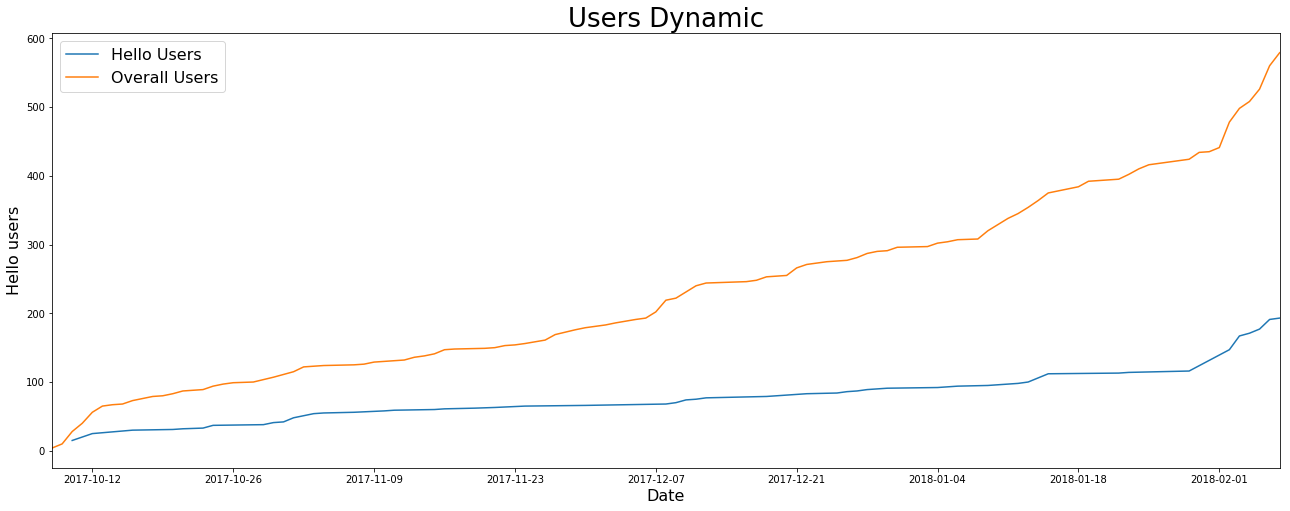

In [13]:
%matplotlib inline
import matplotlib.pylab as plt
plt.title('Users Dynamic', fontsize=26)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Hello users', fontsize=16)
presented_history.value_counts().sort_index().cumsum().plot(figsize=(22,8), label='Hello Users')
total_history.value_counts().sort_index().cumsum().plot(figsize=(22,8), label='Overall Users')
plt.legend(fontsize=16)
plt.savefig('hellousers.png', fps=150)

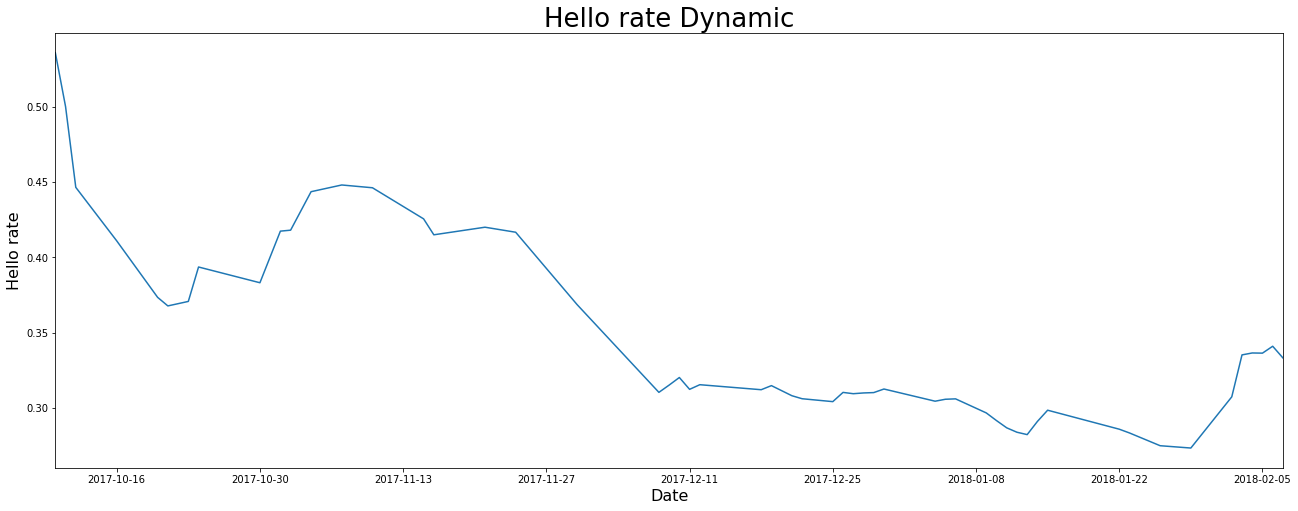

In [14]:
plt.title('Hello rate Dynamic', fontsize=26)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Hello rate', fontsize=16)
(presented_history.value_counts().sort_index().cumsum() / total_history.value_counts().sort_index().cumsum()).dropna().plot(figsize=(22,8))
plt.savefig('hellorate.png', fps=150)

## Silent

In [15]:
silent_list = users_first_action_time[~users_first_action_time.chatname.isin(corpus.chatname.unique())].chatname.sort_values().values
print(silent_list.shape[0])
with open('silent.txt', 'w') as stream:
    stream.write('\n'.join(silent_list))
print('; '.join(silent_list))

266
._Marat(MaraESTJ); A_A(); Abakirov_Nursultan(nabakirov); Abdyldayev_Satbek(satbekmyrza); Ainabekov_Islam(); Akshabayev_Askar(AskarAkshabayev); Almagambetova_Ayanna(submitted); Almaty_Aza(); Altynkhanov_Kuandyk(kuandykzx); Aussat_Miras(aussat); Auyenur_Medet(); B._Ulday(kzbuajh); BM_Madi(Madi_BM); B_A(); B_Bolat(); Babanov_Aidar(babanovshow); Baimurza_Dinmukhammed(qasiwe); Baizhanov_Ali(Ali_Baizhanov); Bakharev_Slava(); Bakhtiyarov_Dias(lgblkb); Bakirov_Ilyas(); Balgimbekov_Galymdin(); Batyrqul_Maqsat(batyrqulmaqsat); Bauyrzhan_Sarsenov(rumblry); Berdimbetova_Gularay(); Bukenov_Samat(bsammy); Bulgakov_Anatoliy(); Bulgakova_Alua(aaxab); Burlakov_Dmitry(Stirch); Dauletkaliyev_Chingis(Chingis01); Davletov_Albert(albert_davletov); Dos_Dos(); Doskaliyev_Issatay(IssatayDoskaliyev); Durden_Tyler(memento99); Dzhangeldin_Alibi(); FIT_J@n@r(Fon2020); Gerbolt_Angelina(angiemelomangie); Gismatulin_Oleg(demokrat312); I_O(Blockcha1ny); Ibrashov_Azamat(); Ibrayev_Abay(dead_1ns1de); Ibrayeva_Madina

## Non presented

In [16]:
non_presented_list = users_first_action_time[~users_first_action_time.chatname.isin(presented)].chatname.sort_values().values
print(non_presented_list.shape[0])
with open('non_presented.txt', 'w') as stream:
    stream.write('\n'.join(non_presented_list))
print('; '.join(non_presented_list))

386
._.(kzdsml); ._Abzal(abzal_a); ._Marat(MaraESTJ); A_A(); Abakirov_Nursultan(nabakirov); Abdyldayev_Satbek(satbekmyrza); Achilova_Alina(achilova); Ainabekov_Islam(); Akshabayev_Askar(AskarAkshabayev); Alikhanov_Murat(codebusterr); Alimbekov_Renat(); Almagambetova_Ayanna(submitted); Almaty_Aza(); Altynkhanov_Kuandyk(kuandykzx); Amanzholov_Marat(deepshadowpixels); Apraimov_Azamat(); Arman Ospanbekov_Arman Ospanbekov(); Asset_Aset(); Assylbekov_Zhenisbek(); Atykhanov_Aman(); Aussat_Miras(aussat); Auyenur_Medet(); B._Ulday(kzbuajh); BM_Madi(Madi_BM); B_A(); B_Bolat(); Babanov_Aidar(babanovshow); Baimurza_Dinmukhammed(qasiwe); Baizhanov_Ali(Ali_Baizhanov); Bakharev_Slava(); Bakhtiyarov_Dias(lgblkb); Bakirov_Ilyas(); Balgimbekov_Galymdin(); Batman_Geek(); Batyr_Vert(HulkTengri); Batyrqul_Maqsat(batyrqulmaqsat); Bauyrzhan_Sarsenov(rumblry); Berdimbetova_Gularay(); Bukenov_Samat(bsammy); Bulgakov_Anatoliy(); Bulgakova_Alua(aaxab); Burlakov_Dmitry(Stirch); Danabek_Kaliazhdarov(Danabek_AIFA);

## Messages number by days

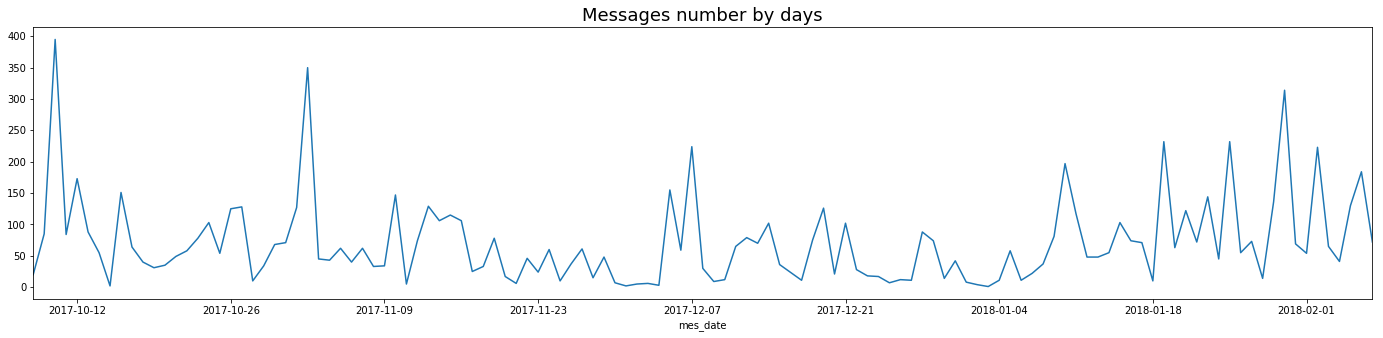

In [17]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.date).count().mes_date.plot(figsize=(24,5))
plt.title('Messages number by days', fontsize=18)
plt.savefig('by date.png', fps=400)

## Messages number by time

Come to work - open the chat)

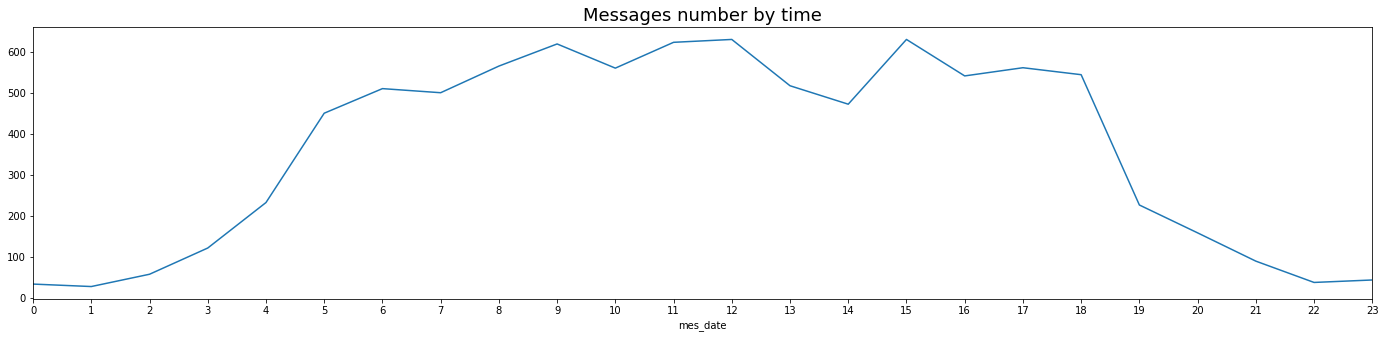

In [18]:
corpus.groupby(corpus.mes_date.dt.hour).count().mes_date.plot(figsize=(24,5))
plt.title('Messages number by time', fontsize=18)
plt.xticks(range(24))
plt.savefig('by hours.png', fps=400)
plt.show()

# Topic model by users

## Splitting messages by users

Messages from one user - one "document"

In [21]:
import pymorphy2

users_text = corpus[corpus.chatname.map((corpus.groupby('chatname')['text'].count() > 50))]

users_text = users_text.groupby('chatname').agg(lambda x: ' '.join(x))['text']

morph = pymorphy2.MorphAnalyzer()

## Part of Speech Filtration

In [22]:
# Apro
def normalise_string(input_str):
    bad_words = {'че','чет','её','ещё','такой','который','какой','очень',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(parsed.normal_form)
    return ' '.join(norm_words_list)

%time users_text_norm = users_text.apply(lambda x: normalise_string(x))
users_text_norm.head()

CPU times: user 6.36 s, sys: 21.6 ms, total: 6.38 s
Wall time: 6.38 s


chatname
Abdikenov_Beibit()         салем весь прийти whatsup группа phd nazarbaye...
Alimbekov_Renat()          весь привет каспи банк активный восстановить l...
Amir_Miras(amirassov)      весь привет звать мираса закончить бакалавр вм...
Balgabekov_Yeldos()        ануар сразу админство плс хороший канал читаем...
Beken_Kazybek(KazybekB)    уважаемый коллега возможность скачать пара мат...
Name: text, dtype: object

In [23]:
def filter_string(input_str):
    bad_words = {'че','чет','её','ещё','такой','который','какой','очень',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(word)
    return ' '.join(norm_words_list)

%time users_text_filter = users_text.apply(lambda x: filter_string(x))
users_text_filter.head()

CPU times: user 7.26 s, sys: 18.6 ms, total: 7.28 s
Wall time: 7.31 s


chatname
Abdikenov_Beibit()         салем всем пришел whatsup группы phd nazarbaye...
Alimbekov_Renat()          всем привет каспи банк активен восстановить li...
Amir_Miras(amirassov)      всем привет зовут мирас закончил бакалавр вмк ...
Balgabekov_Yeldos()        ануар сразу админство плс хороший канал читаем...
Beken_Kazybek(KazybekB)    уважаемые коллеги возможность скачать пару мат...
Name: text, dtype: object

## Some helpers

- Choosing thresholds for vectorization(for removing too frequent and rare words)
- Building lda model (by gensim)
- Reporting results



In [37]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time

def get_words_by_threshold_report(text_series, min_df=0.02, max_df=0.75):
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)

    counts = vectorizer.fit_transform(text_series)
    corpus_id2word = {value: key for key, value in vectorizer.vocabulary_.items()}

    print('Words in dictionary: {}\n'.format(counts.shape[1]))
    print('Dictionary before threshold filtration: ', Counter(' '.join(text_series.values).split()).most_common(20), '\n')

    print('Words under top threshold:   ', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[-40:][::-1]])
    print()
    print('Words upper bottom threshold:', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[:20]])
    return counts, vectorizer, corpus_id2word

def get_lda_model(counts, corpus_id2word, num_topics=10, alpha_value=0.1, var_iter=50, passes=50):
    gensim_corpus = gensim.matutils.Scipy2Corpus(counts)
    t_start = time.time()
    lda = gensim.models.LdaModel(
        corpus=gensim_corpus,
        passes=passes,
        num_topics=num_topics,
        alpha=[alpha_value] * num_topics,
        iterations=var_iter,
        id2word=corpus_id2word,
        eval_every=0,
        random_state=42
    )
    current_score = lda.bound(gensim_corpus)
    time_ellapsed = int(time.time() - t_start)

    print('ELBO = {1:.4f}, time: {2} seconds'.format(
        alpha_value, current_score, time_ellapsed))
    
    gamma, _ = lda.inference(gensim_corpus)
    gamma = gamma / gamma.sum(1).reshape(-1, 1)
    
    return lda, gamma

def build_topic_words_report(lda, top_words_num=25, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    topic_space = max(map(len, topic_names)) + 2
    
    if topic_space==2:
        for topic_index in range(lda.num_topics):
            print('{0} topic: {1}'.format(
                topic_index, ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        return
    
    for topic_index in range(lda.num_topics):
        print('{0} topic :{1: ^{2}}: {3}'.format(
            topic_index, topic_names[topic_index], topic_space,
            ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        
def build_topic_subjects_report(lda, gamma, text_series, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    for topic_index in range(lda.num_topics):
        print('Topic {0} - {1}'.format(topic_index, topic_names[topic_index]))
        best_doc_indexes = gamma[:, topic_index].argsort()[-10:][::-1]
        
        subjects_with_proba = []
        for person_count, doc in enumerate(best_doc_indexes):
            if gamma[doc, topic_index] > 0.01 or person_count<3:
                subjects_with_proba.append('{0} - {1:.1%}'.format(text_series.index[doc], gamma[doc, topic_index]))
        print(', '.join(subjects_with_proba), '\n')


## With words in normal form with weak thresholds

In [38]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_norm, min_df=0.05, max_df=0.85)

Words in dictionary: 3637

Dictionary before threshold filtration:  [('курс', 306), ('дать', 259), ('такой', 200), ('который', 178), ('знать', 170), ('topic', 157), ('делать', 155), ('какой', 153), ('человек', 151), ('хороший', 148), ('быть', 146), ('один', 143), ('задача', 142), ('мочь', 132), ('весь', 131), ('год', 129), ('писать', 127), ('вообще', 126), ('книга', 125), ('думать', 125)] 

Words under top threshold:    ['topic', 'делать', 'какой', 'человек', 'хороший', 'один', 'задача', 'мочь', 'год', 'писать', 'вообще', 'книга', 'probability', 'тема', 'самый', 'работать', 'сделать', 'data', 'хотеть', 'вопрос', 'свой', 'алгоритм', 'пока', 'ml', 'learning', 'работа', 'понять', 'время', 'интересно', 'написать', 'читать', 'поэтому', 'нужный', 'статья', 'код', 'сказать', 'анализ', 'говорить', 'давать', 'тот']

Words upper bottom threshold: ['лирический', 'пригласить', 'вместить', 'приговор', 'влияние', 'владеть', 'вкус', 'пригодиться', 'привязать', 'вк', 'визуально', 'визуализировать', 'п

In [32]:
lda_norm, gamma_norm = get_lda_model(counts, corpus_id2word, num_topics=10)

ELBO = -233490.4151, time: 15 seconds


In [35]:
build_topic_words_report(lda_norm, top_words_num=15)

0 topic: какой, работа, харатс, мб, смотреть, аналитик, ата, работать, анализ, год, место, посмотреть, слово, время, собеседование
1 topic: книга, data, человек, какой, мочь, делать, год, phd, статья, ml, проходить, хороший, специализация, один, тема
2 topic: книга, ds, один, тема, acm, сделать, самый, человек, learning, другой, хотеть, работа, вопрос, должный, ml
3 topic: topic, один, хороший, probability, работать, человек, делать, мочь, задача, год, data, книга, вопрос, сделать, какой
4 topic: делать, опыт, задача, мочь, система, сказать, хотеть, команда, писать, человек, работа, норма, решение, пока, хороший
5 topic: задача, делать, год, сделать, вообще, какой, один, самый, мочь, работать, щас, learning, хороший, читать, поэтому
6 topic: человек, тип, иметь, интересно, python, астан, год, data, вообще, сказать, читать, давать, рахмет, место, мой
7 topic: ml, книга, том, data, делать, вопрос, какой, задача, сделать, иметь, theory, понять, learning, писать, самый
8 topic: человек, по

In [34]:
build_topic_subjects_report(lda_norm, gamma_norm, users_text_norm)

Topic 0 - 
Хуснутдинова_Женя() - 99.8%, _45954(Hmmmmm123) - 0.1%, _‏‏‎(rlymdk) - 0.1% 

Topic 1 - 
_Adil(adilkhash) - 99.9%, Нурышев_Нуржан() - 99.9%, Jaraisyn_Virus(Giganotosaurus) - 99.8%, Panaberdiyev_Yerbol(YerbolPanaberdiyev) - 99.7%, Makhmudov_Lecha(otrakid) - 99.7%, Abdikenov_Beibit() - 11.1% 

Topic 2 - 
Дуйсенбаев_Азамат(azicon) - 99.6%, _45954(Hmmmmm123) - 0.1%, _‏‏‎(rlymdk) - 0.1% 

Topic 3 - 
_45954(Hmmmmm123) - 0.1%, _‏‏‎(rlymdk) - 0.1%, _Sagimbayev Zhuldyzzhan(cruigo93) - 0.0% 

Topic 4 - 
_Айдос() - 99.9%, _Дархан(hoogleraar) - 99.9%, Krts_Dima() - 99.8%, _TMT() - 16.4%, Abdikenov_Beibit() - 10.2% 

Topic 5 - 
Alimbekov_Renat() - 99.9%, _novitoll(novitoll) - 99.9%, _‏‏‎(rlymdk) - 99.5%, _Ерзат Книжка(higgsfield) - 82.1%, Z_Almaz(almaz_zinollayev) - 76.6%, Maratkhan_Anuar(ardulat) - 55.3%, Amir_Miras(amirassov) - 51.7%, Abdikenov_Beibit() - 23.4% 

Topic 6 - 
Mamrayev_Galymbek() - 99.8%, _Жақсылық(zsabay) - 99.7%, _45954(Hmmmmm123) - 0.1% 

Topic 7 - 
_Azamat(aberdysh) - 

## With words in normal form with strong thresholds

In [44]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_norm, min_df=0.025, max_df=0.45)
lda_norm_45, gamma_norm_45 = get_lda_model(counts, corpus_id2word, num_topics=10)

Words in dictionary: 10267

Dictionary before threshold filtration:  [('курс', 306), ('дать', 259), ('такой', 200), ('который', 178), ('знать', 170), ('topic', 157), ('делать', 155), ('какой', 153), ('человек', 151), ('хороший', 148), ('быть', 146), ('один', 143), ('задача', 142), ('мочь', 132), ('весь', 131), ('год', 129), ('писать', 127), ('вообще', 126), ('книга', 125), ('думать', 125)] 

Words under top threshold:    ['topic', 'probability', 'python', 'норма', 'dl', 'щас', 'язык', 'питон', 'phd', 'типо', 'мб', 'система', 'теория', 'последний', 'обучение', 'чат', 'deep', 'rl', 'сразу', 'сетка', 'выйти', 'статистика', 'спрашивать', 'программа', 'специализация', 'далёкий', 'аналитик', 'знание', 'друг', 'science', 'сам', 'гугл', 'математика', 'мгу', 'датасет', 'наверное', 'дс', 'идти', 'theory', 'русский']

Words upper bottom threshold: ['04s', 'критически', 'критика', 'кристина', 'кризис', 'кривой', 'креветка', 'крашнуться', 'краулер', 'красть', 'красный', 'красивенький', 'критично', 

In [66]:
build_topic_words_report(
    lda_norm_45, top_words_num=14,
    topic_names=['Шад', 'Прокуратура', 'Обучение', '', 'Хайп', 'Админи-е', 'Теория', 'phd', 'Аналитика', 'Видюхи'] * 10)

0 topic :     Шад     : topic, probability, крч, дс, мб, типо, конф, яндекс, шада, целое, текст, всякий, норма, тест
1 topic : Прокуратура : система, прокуратура, орган, блокчейн, внедрение, прокурор, аналитический, генеральный, адм, python, норма, программа, почитать, аналитик
2 topic :  Обучение   : специализация, почитать, python, советовать, больший, материал, язык, лекция, spark, сильно, идти, друг, игра, норма
3 topic :             : topic, probability, крч, дс, типо, мб, теория, норма, python, язык, целое, наверное, яндекс, конф
4 topic :    Хайп     : щас, rl, сетка, dl, типо, далёкий, архитектура, граф, deep, gpu, последний, сразу, теория, хайп
5 topic :  Админи-е   : питон, python, чат, язык, sql, купить, server, xml, наверное, быстрый, система, ответ, друг, датасет
6 topic :   Теория    : theory, manifold, etc, optimization, na, np, учебник, non, linear, space, function, matrix, paper, number
7 topic :     phd     : phd, программа, салем, статистика, dl, норма, примерно, мат

In [67]:
build_topic_subjects_report(lda_norm_45, gamma_norm_45, users_text_norm)

Topic 0 - 
Аймолдин_Ануар(cSneddy) - 100.0%, Taskynov_Anuar(TaskynovAnuar) - 92.5%, _45954(Hmmmmm123) - 0.1% 

Topic 1 - 
Krts_Dima() - 99.8%, _45954(Hmmmmm123) - 0.1%, _‏‏‎(rlymdk) - 0.1% 

Topic 2 - 
_Adil(adilkhash) - 99.9%, Alimbekov_Renat() - 99.9%, _TMT() - 99.7%, Makhmudov_Lecha(otrakid) - 99.7%, Дуйсенбаев_Азамат(azicon) - 99.6%, _‏‏‎(rlymdk) - 99.5% 

Topic 3 - 
_45954(Hmmmmm123) - 0.1%, _‏‏‎(rlymdk) - 0.1%, _Sagimbayev Zhuldyzzhan(cruigo93) - 0.1% 

Topic 4 - 
_Ерзат Книжка(higgsfield) - 100.0%, _45954(Hmmmmm123) - 0.1%, _‏‏‎(rlymdk) - 0.1% 

Topic 5 - 
_Aktan Akhmetov() - 100.0%, Balgabekov_Yeldos() - 99.9%, Jaraisyn_Virus(Giganotosaurus) - 99.8%, Mamrayev_Galymbek() - 99.8%, Raimkulov_Azat(AzatRZ) - 99.8%, _Мухаммад(grizzly_puma) - 99.7%, Amir_Miras(amirassov) - 99.6%, Danabek_Kaliazhdarov(Danabek_AIFA) - 99.6% 

Topic 6 - 
_Azamat(aberdysh) - 100.0%, Beken_Kazybek(KazybekB) - 99.8%, Z_Almaz(almaz_zinollayev) - 99.7%, Taskynov_Anuar(TaskynovAnuar) - 7.4% 

Topic 7 - 
Abdike

## With words in free form with strong thresholds

In [81]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_filter, min_df=0.04, max_df=0.65)

Words in dictionary: 4556

Dictionary before threshold filtration:  [('topic', 157), ('данных', 145), ('курс', 136), ('вообще', 126), ('probability', 120), ('data', 110), ('ml', 94), ('пока', 94), ('learning', 93), ('интересно', 86), ('поэтому', 81), ('всем', 78), ('думаю', 77), ('которые', 76), ('знаю', 76), ('такое', 72), ('r', 71), ('понял', 68), ('python', 67), ('делать', 67)] 

Words under top threshold:    ['topic', 'probability', 'learning', 'поэтому', 'понял', 'python', 'делать', 'вопрос', 'ds', 'мл', 'норм', 'курсы', 'курса', 'рахмет', 'dl', 'могу', 'книга', 'будут', 'щас', 'тема', 'круто', 'phd', 'код', 'сделать', 'типо', 'кз', 'людей', 'мб', 'типа', 'работы', 'rl', 'deep', 'сразу', 'привет', 'работает', 'человек', 'лет', 'буду', 'почему', 'задачи']

Words upper bottom threshold: ['митапа', 'пользуются', 'пользователя', 'всякими', 'семейным', 'семестр', 'семинарах', 'лучшая', 'получше', 'встречаемся', 'семьи', 'сели', 'сервак', 'вскоре', 'всерьез', 'получения', 'всеми', 'люба

In [82]:
lda, gamma = get_lda_model(counts, corpus_id2word, num_topics=10)

ELBO = -214974.5862, time: 19 seconds


In [83]:
build_topic_words_report(lda, top_words_num=15)

0 topic: щас, learning, rl, поэтому, dl, курса, типо, кз, deep, дальше, сразу, python, код, сделать, круто
1 topic: задач, проц, мб, лол, посмотреть, момент, купить, ии, дело, neural, сути, software, np, тяжко, поэтому
2 topic: привет, модель, норм, понял, мат, людей, точно, почитать, алматы, датасет, будем, первый, python, эта, делать
3 topic: topic, probability, тема, дс, курсы, мб, phd, типо, курса, онлайн, общем, мгу, прост, мл, проходил
4 topic: theory, manifold, etc, na, learning, optimization, non, linear, space, function, number, matrix, paper, probability, np
5 topic: python, опыт, делать, sql, вопрос, типа, рахмет, работы, сделать, понял, xml, server, код, знание, наверное
6 topic: мл, норм, поэтому, могу, харатс, посмотреть, кз, learning, лол, давайте, хотел, python, типа, книга, вопрос
7 topic: астане, курсы, вопрос, будут, ребята, мл, делать, cv, 1080ti, кайрат, сами, долларов, поэтому, работы, тд
8 topic: ds, книга, learning, щас, поэтому, мл, python, точно, могу, вопрос,

In [84]:
build_topic_subjects_report(lda, gamma, users_text_filter)

Topic 0 - 
_Ерзат Книжка(higgsfield) - 100.0%, _Adil(adilkhash) - 99.9%, Danabek_Kaliazhdarov(Danabek_AIFA) - 99.5%, Mamrayev_Galymbek() - 42.9% 

Topic 1 - 
Jaraisyn_Virus(Giganotosaurus) - 99.8%, Z_Almaz(almaz_zinollayev) - 99.7%, _45954(Hmmmmm123) - 0.1% 

Topic 2 - 
Alimbekov_Renat() - 99.9%, _45954(Hmmmmm123) - 0.1%, _‏‏‎(rlymdk) - 0.1% 

Topic 3 - 
Аймолдин_Ануар(cSneddy) - 100.0%, Taskynov_Anuar(TaskynovAnuar) - 99.9%, Нурышев_Нуржан() - 99.8%, Beken_Kazybek(KazybekB) - 99.8%, _TMT() - 99.7%, Krts_Dima() - 35.9%, Mamrayev_Galymbek() - 32.2% 

Topic 4 - 
_Azamat(aberdysh) - 100.0%, Krts_Dima() - 22.0%, _45954(Hmmmmm123) - 0.1% 

Topic 5 - 
_Aktan Akhmetov() - 100.0%, _Айдос() - 99.9%, Balgabekov_Yeldos() - 99.8%, Raimkulov_Azat(AzatRZ) - 99.7%, _45954(Hmmmmm123) - 99.2%, Krts_Dima() - 41.9%, Mamrayev_Galymbek() - 24.7% 

Topic 6 - 
_Дархан(hoogleraar) - 99.9%, Хуснутдинова_Женя() - 99.7%, Maratkhan_Anuar(ardulat) - 99.7%, _Жақсылық(zsabay) - 99.7%, Дуйсенбаев_Азамат(azicon) - 99.

# Topic models by week

In [85]:
week_text = corpus.groupby(corpus.mes_date.apply(lambda x: '{1}-{0}'.format(x.week, x.year))).agg(lambda x: ' '.join(x))['text']
print(week_text.shape)
week_text.head()

(19,)


mes_date
2017-40    ануар сразу админство плс крч всем привет созд...
2017-41    учителя востребованы раньше coursera помогаем ...
2017-42    общем правило представляться вновь прибывшим б...
2017-43    советую ознакомиться kafka kafka streaming api...
2017-44    продолжению треду information bottleneck numer...
Name: text, dtype: object

In [95]:
morph = pymorphy2.MorphAnalyzer()
%time week_text_filter = week_text.apply(lambda x: normalise_string(x))
week_text_filter.head()

CPU times: user 8.8 s, sys: 64 ms, total: 8.86 s
Wall time: 8.87 s


mes_date
2017-40    ануар сразу админство плс крч весь привет созд...
2017-41    учитель востребовать ранний coursera помогать ...
2017-42    общий правило представляться вновь прибыть бук...
2017-43    советовать ознакомиться kafka kafka streaming ...
2017-44    продолжение тред information bottleneck numeri...
Name: text, dtype: object

In [136]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_filter, min_df=0.06, max_df=0.8)

Words in dictionary: 4511

Dictionary before threshold filtration:  [('курс', 399), ('дать', 347), ('весь', 270), ('такой', 247), ('работать', 223), ('hello', 220), ('который', 215), ('знать', 214), ('задача', 207), ('год', 204), ('data', 199), ('делать', 199), ('человек', 194), ('быть', 190), ('хороший', 190), ('мочь', 189), ('ml', 189), ('какой', 188), ('один', 187), ('думать', 168)] 

Words under top threshold:    ['probability', 'модель', 'science', 'язык', 'команда', 'питон', 'метод', 'новый', 'теория', 'программа', 'чат', 'уровень', 'посмотреть', 'слово', 'dl', 'онлайн', 'пара', 'начинать', 'мб', 'щас', 'идея', 'rl', 'математика', 'типо', 'решать', 'алматы', 'мгу', 'программирование', 'сам', 'маленький', 'сразу', 'дс', 'смысл', 'неделя', 'ai', 'пройти', 'решить', 'сложный', 'бизнес', 'выйти']

Words upper bottom threshold: ['өзіңді', 'питончик', 'питорча', 'result', 'resources', 'resnet', 'иконка', 'взглянуть', 'имплементация', 'requirements', 'плавный', 'плагин', 'изобретать', '

In [137]:
lda_week, gamma_week = get_lda_model(counts, corpus_id2word, num_topics=10)

ELBO = -265031.8391, time: 18 seconds


In [138]:
build_topic_words_report(lda_week, top_words_num=15)

0 topic: финансовый, математика, порядок, стажировка, вес, yahoo, weights, weight, юзать, обычный, фин, function, маленький, мб, мат
1 topic: probability, модель, чат, язык, уровень, sql, программа, питон, rl, kz, посмотреть, мгу, сразу, слово, решать
2 topic: новый, теория, сетка, онлайн, tsp, обезьяна, пройти, тест, канал, команда, немного, маленький, программирование, сильный, ne
3 topic: специализация, dl, хакатон, big, бот, neural, сетка, rl, щас, друг, язык, чувак, мфть, spark, лекция
4 topic: science, зп, мб, шада, идти, модель, пятница, слой, вуз, вакансия, дс, сеть, метод, автор, город
5 topic: np, optimization, non, обзор, hard, convex, теория, автор, отчёт, intelligence, труд, математика, модель, dl, реальный
6 topic: ai, митапа, встреча, онлайн, science, команда, manifold, питон, вариант, суббота, matrix, неделя, сам, number, посмотреть
7 topic: метод, байес, граф, слово, матрица, модель, theory, типо, pca, тф, пара, mcmc, команда, организация, щас
8 topic: probability, мод

In [139]:
def weekpair_2date(pair):
    atime = time.strptime('{} {} 1'.format(*pair.split('-')), '%Y %W %w')
    return pd.to_datetime('{0}-{1}-{2}'.format(atime.tm_year, atime.tm_mon, atime.tm_mday))

topic_dynamic = pd.DataFrame(week_text_filter)
topic_dynamic['topic'] = np.argmax(gamma_week, axis=1)
topic_dynamic['message_count'] = week_text.apply(len)
topic_dynamic['date'] = list(map(weekpair_2date, topic_dynamic.index))
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-40,ануар сразу админство плс крч весь привет созд...,6,730,2017-10-02
2017-41,учитель востребовать ранний coursera помогать ...,6,37639,2017-10-09
2017-42,общий правило представляться вновь прибыть бук...,1,30056,2017-10-16
2017-43,советовать ознакомиться kafka kafka streaming ...,4,24609,2017-10-23
2017-44,продолжение тред information bottleneck numeri...,7,40993,2017-10-30


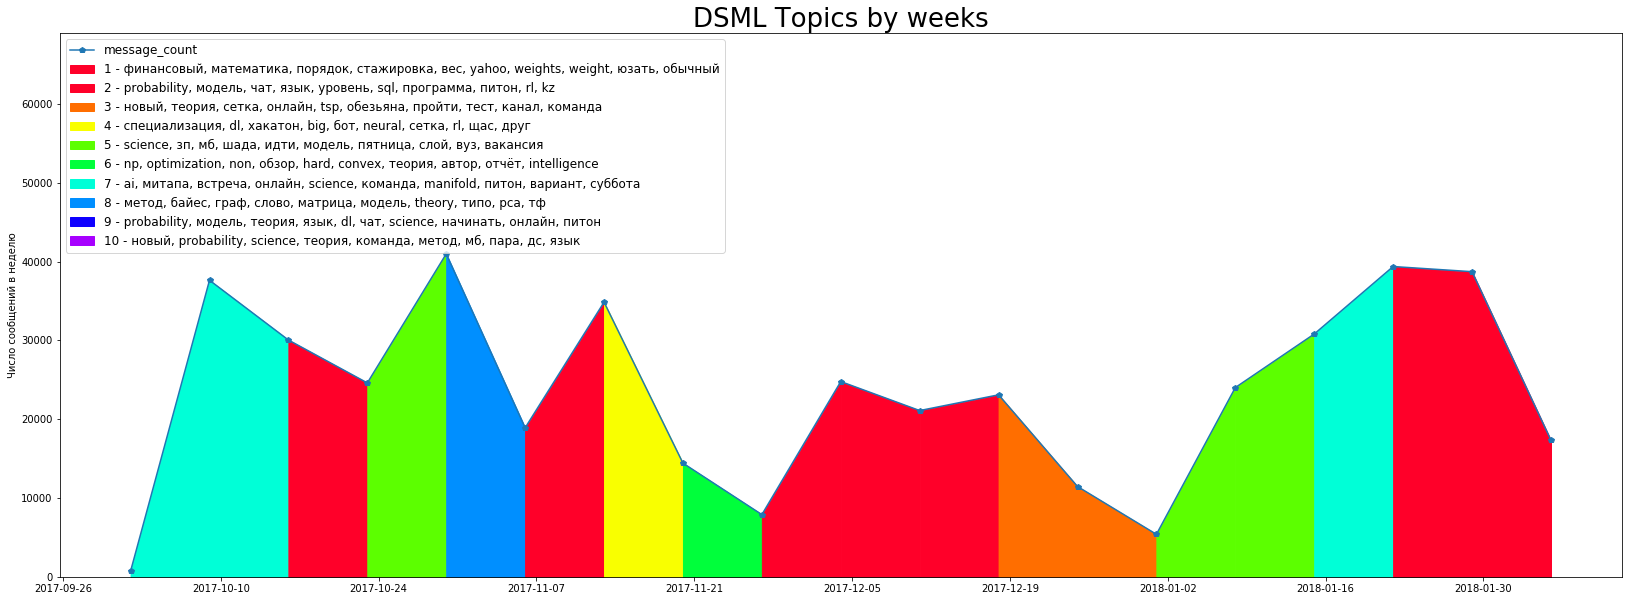

In [140]:
import matplotlib as mpl
cmap = mpl.cm.gist_rainbow
normalize = mpl.colors.Normalize(vmin=1, vmax=10)
cmap(normalize(3))

plt.figure(figsize=(28,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(lda_week.num_topics):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )

plt.ylim(0, 69000)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('Число сообщений в неделю')
plt.title('DSML Topics by weeks', fontsize=26)
plt.savefig('topic_history.png')
plt.show()

# Topic models by days

In [141]:
day_text = corpus.groupby(corpus.mes_date.dt.date).agg(lambda x: ' '.join(x))['text']
print(day_text.shape)
day_text.head()

(122,)


mes_date
2017-10-08    ануар сразу админство плс крч всем привет созд...
2017-10-09    учителя востребованы раньше coursera помогаем ...
2017-10-10    вроде отдельно ребят связи постами выше хотело...
2017-10-11    доброе утро астане вообще проживает тому собра...
2017-10-12    вкусы весьма специфичны import xgbregressor kn...
Name: text, dtype: object

In [142]:
morph = pymorphy2.MorphAnalyzer()
%time day_text_norm = day_text.apply(lambda x: normalise_string(x))
day_text_norm.head()

CPU times: user 11.5 s, sys: 12 ms, total: 11.5 s
Wall time: 11.5 s


mes_date
2017-10-08    ануар сразу админство плс крч весь привет созд...
2017-10-09    учитель востребовать ранний coursera помогать ...
2017-10-10    отдельно ребята связь пост выше хотеться поинт...
2017-10-11    добрый утро астан вообще проживать тот собрать...
2017-10-12    вкус весьма специфичный import xgbregressor kn...
Name: text, dtype: object

In [156]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(day_text_norm, min_df=0.01, max_df=0.55)

Words in dictionary: 4801

Dictionary before threshold filtration:  [('курс', 399), ('дать', 347), ('весь', 270), ('такой', 247), ('работать', 223), ('hello', 220), ('который', 215), ('знать', 214), ('задача', 207), ('год', 204), ('data', 199), ('делать', 199), ('человек', 194), ('быть', 190), ('хороший', 190), ('мочь', 189), ('ml', 189), ('какой', 188), ('один', 187), ('думать', 168)] 

Words under top threshold:    ['hello', 'задача', 'data', 'человек', 'быть', 'ml', 'думать', 'писать', 'topic', 'тема', 'сделать', 'работа', 'самый', 'пока', 'книга', 'интересно', 'learning', 'время', 'свой', 'вопрос', 'алгоритм', 'проект', 'probability', 'компания', 'анализ', 'понять', 'ds', 'опыт', 'python', 'заниматься', 'читать', 'использовать', 'сказать', 'написать', 'звать', 'другой', 'говорить', 'астан', 'поэтому', 'тот']

Words upper bottom threshold: ['өзіңді', 'баейс', 'бабла', 'ахи', 'ахахах', 'аха', 'африка', 'аутсорс', 'аудиторский', 'аудио', 'аугментация', 'атрибут', 'ассоциация', 'ассоци

In [157]:
lda_day_norm, gamma_day_norm = get_lda_model(counts, corpus_id2word)

ELBO = -339208.1895, time: 31 seconds


In [158]:
build_topic_words_report(lda_day_norm, top_words_num=15)

0 topic: matrix, kz, number, книга, купить, евро, learning, писать, сервис, see, доставка, ai, дс, стоить, elements
1 topic: работа, ai, проект, хакатон, data, свой, том, тема, google, phd, сделать, ml, питон, rl, проходить
2 topic: задача, книга, data, быть, человек, learning, алгоритм, ml, вопрос, писать, самый, интересно, думать, время, компания
3 topic: человек, быть, свой, думать, хайп, проект, пока, наш, студент, рынок, дата, поэтому, сделать, кз, neural
4 topic: data, думать, тема, работа, быть, писать, hello, задача, ml, человек, анализ, python, время, использовать, сделать
5 topic: человек, прокуратура, найти, система, дело, data, сказать, самый, вопрос, думать, место, свой, проект, быть, говорить
6 topic: hello, звать, ml, ds, мл, заниматься, сделать, изучать, задача, день, писать, пока, manifold, анализ, интересно
7 topic: новый, быть, выйти, понять, сделать, data, думать, сказать, крутой, время, модель, пример, говорить, друг, функция
8 topic: spark, na, phd, time, клиент, 

In [159]:
topic_dynamic = pd.DataFrame(day_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_day_norm, axis=1)
topic_dynamic['message_count'] = day_text.apply(len)
topic_dynamic['date'] = topic_dynamic.index
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-10-08,ануар сразу админство плс крч весь привет созд...,2,730,2017-10-08
2017-10-09,учитель востребовать ранний coursera помогать ...,2,3742,2017-10-09
2017-10-10,отдельно ребята связь пост выше хотеться поинт...,4,16767,2017-10-10
2017-10-11,добрый утро астан вообще проживать тот собрать...,4,4595,2017-10-11
2017-10-12,вкус весьма специфичный import xgbregressor kn...,4,6502,2017-10-12


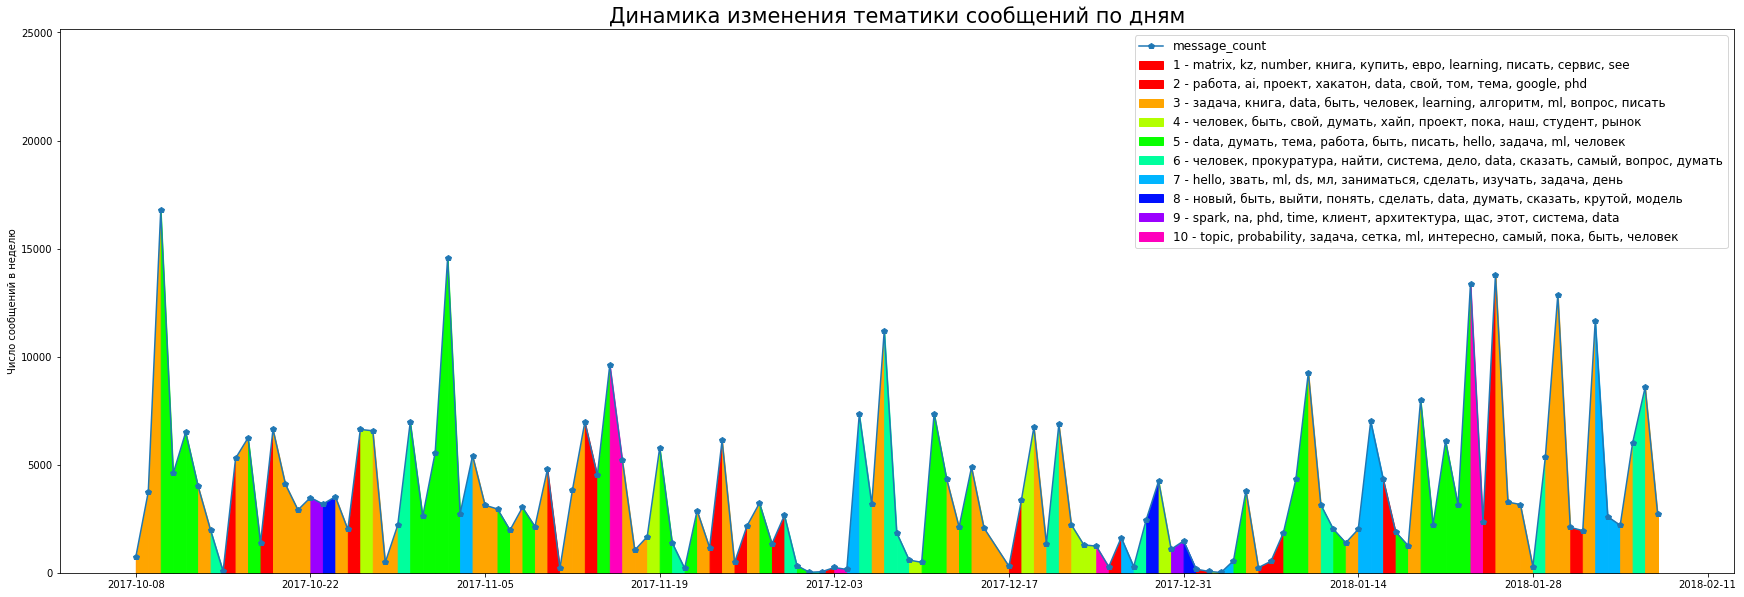

In [160]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_day_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Число сообщений в неделю')
plt.title('Динамика изменения тематики сообщений по дням', fontsize=21)
plt.savefig('dsml_day_dynamic_norm_v2.png')
plt.show()